\author{Brice Robert} 

***Student:*** Brice Robert, ***Track:*** ICS

***Document:*** REPORT.pdf, ***Type:*** Laboratory

***Languages used:*** LaTeX, Julia (in lieu of MATLAB)

***Tools used:*** Jupyter, nbconvert (converting to PDF)

***Permanent Link:*** https://github.com/setrar/MobCom/blob/main/Lab/REPORT.ipynb

| MATLAB PROJECT for MOBCOM |
|:-:|
| EURECOM |
| November 21st, 2024 |
| Class Instructor: Petros Elia |
| elia@eurecom.fr |

- Read carefully the following questions, and using MATLAB, provide the answers/plots in the form of a report.
- The report should include a title page, and should be properly labeled and named. The report should be in the form of a PDF.
- Graphs should include labels, titles, and captions.
- Each graph should be accompanied with pertinent comments.
- Use optimal (maximum likelihood) decoders, unless stated otherwise.
- To compare the empirical results with the corresponding theoretical result, you should superimpose the two corresponding graphs and provide comments and intuition on the comparison.
- For each plot, describe the theoretical background that guides the proper choice of parameters for simulations (i.e., power constraint).
- You can work in groups of two or three.


- Regarding Grading:
    - All questions are weighted equally.
    - Submit your report (labeled and named) via email, to Hui Zhao (Hui.Zhao@eurecom.fr) and to myself.
    - Submission deadline is December 12th, 2024.




Enjoy!






---
**$$\text{PROBLEM 1}$$**

Consider communication over the $1 \times 1$ quasi-static fading channel, using 16-PAM. The channel model is given by  

$$
\overbrace{( y )}^{y} = \theta \overbrace{(h)}^{h} \overbrace{(x)}^{\text{16-PAM:}X_{\text{tr}}} + \overbrace{( w )}^{w}
$$

where $h \sim \mathbb{C}N(0, 1)$ (Gaussian Fading) and $w \sim \mathbb{C}N(0, 2)$, and where $\theta$ is the power normalization factor that lets you regulate SNR.  

Here, you are supposed to do a simulation of the action of decoding. **PROVIDE THE DETAILS OF HOW YOU SIMULATED.** Tell us which variables you change in each iteration: $h$, codewords, noise, and tell us how you power normalize (emphasis on $\theta$) so that you achieve a certain signal-to-noise ratio (SNR). Naturally, in each iteration, you decode, using the maximum-likelihood (ML) rule that we learned about:

$\hat{x} = \arg \min_{x \in \mathcal{X}_{\text{tr}}} \|y - \theta h \cdot x \|^2$

going over all choices of $x$ in the code $\mathcal{X}_{\text{tr}}$.

**NOTE:** Do many iterations so that your plots are "smooth." In all the above, the y-axis is the probability of error, in log scale ($\log_{10}(\text{Prob})$), and the x-axis is the SNR, in dB.  

- **Plot the probability of error** on a logarithmic scale as a function of SNR (dB) by performing Monte-Carlo simulations for when $x$ are independently chosen from 16-PAM.  

For the above, use the ML decoder, and plot for SNR values — in steps of 3 dB — up to an SNR value for which your probability of error drops below $5 \times 10^{-5}$. **Again, clearly explain how you calculate $\theta$ in each case.**  

---
Import Required Libraries


In [1]:
using Random
using Distributions
using LinearAlgebra
using Plots, LaTeXStrings, Measures 
using FFTW

In [2]:
# functions and variables to increase readability
include("modules/operations.jl");

In [3]:
# Define base values and offsets
# base_values = [-0.00, -0.50, -1.00, -1.50, -2.00]
# offsets = [-0.0, -0.02, -0.10, -0.15, -0.20, -0.30, -0.40, -0.70]
include("modules/view_helper.jl");

Step 2: Define Parameters

Set the simulation parameters:

In [4]:
# Parameters (only the constants)
const M = 16  # 16-PAM
const σ² = 2.0  # Noise variance
const SNR_dB_range = 0:3:30;  # SNR range in dB

Step 3: Generate 16-PAM Symbol Set

Define the 16-PAM constellation:

In [5]:
# Generate 16-PAM constellation
function generate_16pam()
    levels = -15:2:15  # PAM levels
    return collect(levels)  # Return as an array
end

Xₜᵣ = generate_16pam() ; @show typeof(Xₜᵣ), Xₜᵣ;  # Shows the Transmitted symbol set

(typeof(Xₜᵣ), Xₜᵣ) = (Vector{Int64}, [-15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15])


Step 4: Define Channel Model and Noise

1.	Gaussian Fading Channel ($\tilde{h} \sim \mathcal{CN}(0, 1)$):

In [6]:
# Generate Gaussian fading channel
function generate_gaussian_fading(n)
    real_part = rand(Normal(0, 1), n)  # Real part
    imag_part = rand(Normal(0, 1), n)  # Imaginary part
    return real_part .+ im .* imag_part  # Complex Gaussian
end;

2.	Additive Noise $(\tilde{w} \sim \mathcal{CN}(0, \sigma²))$:

In [7]:
# Generate complex Gaussian noise
function generate_noise(n, σ²)
    real_part = rand(Normal(0, sqrt(σ² / 2)), n)
    imag_part = rand(Normal(0, sqrt(σ² / 2)), n)
    return real_part .+ im .* imag_part
end;

Step 5: Power Normalization

Compute the normalization factor $\theta$ based on the $SNR$:

In [8]:
# Compute power normalization factor
function compute_θ(SNR_dB, σ², Xₜᵣ)
    SNRₗᵢₙₑₐᵣ = 10^(SNR_dB / 10)  # Convert SNR from dB to linear scale
    Pₓ = mean(abs2.(Xₜᵣ))  # Average power of 16-PAM symbols
    return sqrt((SNRₗᵢₙₑₐᵣ * σ²) / Pₓ)  # Calculate θ
end;

Step 6: ML Decoding Rule

Implement the ML decoding rule:

In [9]:
# ML decoding
function ml_decode(ŷ, h, θ, Xₜᵣ)
    distances = abs2.(ŷ .- θ .* h .* Xₜᵣ)  # Compute distances for all symbols
    idx = argmin(distances)  # Find the index of the minimum distance
    return Xₜᵣ[idx]  # Return the estimated symbol
end;

Step 7: Monte Carlo Simulation

Simulate the system and calculate the probability of error:

In [10]:
# Monte Carlo simulation
function monte_carlo_simulation(SNR_dB_range, n_samples, σ², X_tr)
    P_error = Float64[]

    for SNR_dB in SNR_dB_range
        θ = compute_θ(SNR_dB, σ², X_tr)  # Compute normalization factor
        h = generate_gaussian_fading(n_samples)  # Generate fading coefficients
        x = rand(X_tr, n_samples)  # Randomly transmit symbols
        w = generate_noise(n_samples, σ²)  # Generate noise
        ŷ = θ .* h .* x .+ w  # Received signal

        # Perform decoding
        x̂ = [ml_decode(ŷ[i], h[i], θ, X_tr) for i in 1:n_samples]

        # Compute error probability
        error_count = count(x .!= x̂)
        push!(P_error, error_count / n_samples)
    end

    return P_error
end;

Step 8: Plot Results

Plot the probability of error vs. SNR (logarithmic scale):

P_error = [0.795729, 0.739592, 0.662678, 0.565059, 0.449377, 0.325523, 0.213096, 0.126839, 0.070344, 0.037851, 0.019214]


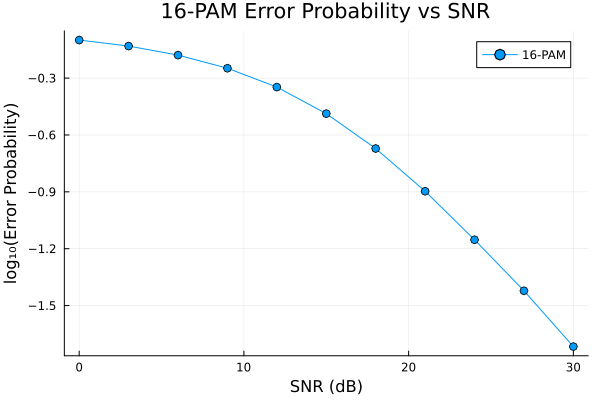

In [11]:
# Parameters
n_samples = 10^6  # Number of Monte Carlo samples

# Run the simulation
P_error = monte_carlo_simulation(SNR_dB_range, n_samples, σ², Xₜᵣ); @show P_error;

# Plot results
plot(SNR_dB_range, log10.(P_error)
    , marker=:o, label="16-PAM"
    , xlabel="SNR (dB)", ylabel="log₁₀(Error Probability)"
    , title="16-PAM Error Probability vs SNR"
    , grid=true
)
# add_combined_hlines!(offsets, base_values, linestyle=:dash, lw=1, color=:gray, alpha=0.3)


---
**$$\text{PROBLEM 2}$$**


- **Use simulations to establish the probability of deep fade**  

$$
P(\|h\|^2 < \text{SNR}^{-1})
$$

for the random fading model:

$$
y = h \cdot x + w
$$

where $w \sim \mathbb{C}N(0, 1)$, and where $h$ is a Rician random variable, where you can choose the parameters of this distribution.

- **Now do the same when $h$ is now a 3-length vector with i.i.d. Rician elements.**

In all the above, the y-axis is the probability of deep fade, in log scale ($\log_{10}(\text{Prob})$), and the x-axis is the SNR, in dB.

---

Step-by-step implementation in `Julia`, including simulations for both a single `Rician fading coefficient` and a `3-length vector` of i.i.d. Rician fading elements.

# **Mathematical Model**

- The random fading model is:
  $y = h \cdot x + w,$
  where:
  - $h$: Rician fading random variable.
  - $x$: Transmitted signal (can be any constant since it’s irrelevant for this computation).
  - $w \sim \mathbb{C}N(0, 1)$: Complex Gaussian noise.

- Deep fade probability:
  $P(\|h\|^2 < \text{SNR}^{-1}),$
  where:
  - $\|h\|^2$ is the power of the fading channel.
  - $\text{SNR} = 10^{\text{SNR}_{\text{dB}} / 10}$.

For a 3-length vector of i.i.d. Rician fading elements:
$\|h\|^2 = \sum_{i=1}^3 |h_i|^2,$
where $h_i$ are i.i.d. Rician variables.

# **Simulation Steps**



#### **Step 1: Generate Rician Fading Coefficients**
A Rician fading random variable $h$ is parameterized by:
- $K$: The Rician $K$-factor (ratio of LOS to NLOS power).
- $\sigma$: The standard deviation of the NLOS component.

The Rician fading can be generated as:
$h = v + z,$
where:
- $v$: Deterministic LOS component ($v = \sqrt{K / (K+1)}$).
- $z \sim \mathbb{C}N(0, \sigma^2 / 2)$: Complex Gaussian NLOS component.



In [12]:
# Generate Rician fading
function generate_rician(n, K, σ)
    ν = sqrt(K / (K + 1))  # LOS component
    σ_r = σ / sqrt(2 * (K + 1))  # NLOS component
    real = rand(Normal(ν, σ_r), n)
    imag = rand(Normal(0, σ_r), n)
    return real .+ j .* imag  # Complex Rician fading
end;

#### **Step 2: Compute $\|h\|^2$**
For the single random variable $h$:

In [13]:
# Compute magnitude squared for single Rician variable
function compute_magnitude_squared(h)
    return abs2.(h)  # Compute |h|^2 for all samples
end;

For the 3-length vector:

In [14]:
# Compute magnitude squared for a 3-length Rician vector
function compute_vector_magnitude_squared(h_vector::Matrix{ComplexF64})
    return sum(abs2, h_vector, dims=1)  # Sum squared magnitudes along rows
end;

#### **Step 3: Compute Probability of Deep Fade**
Evaluate the probability:
$P(\|h\|^2 < \text{SNR}^{-1})$
for a range of SNR values.

In [15]:
# Compute deep fade probability
function deep_fade_probability(h, SNR_range)
    probabilities = Float64[]
    for SNR_dB in SNR_range
        SNR_linear = 10^(SNR_dB / 10)  # Convert dB to linear scale
        threshold = 1 / SNR_linear
        fade_count = count(x -> x < threshold, compute_magnitude_squared(h))
        push!(probabilities, fade_count / length(h))
    end
    return probabilities
end

# Compute deep fade probability for vector
function deep_fade_probability_vector(h_vector, SNR_range)
    probabilities = Float64[]
    for SNR_dB in SNR_range
        SNR_linear = 10^(SNR_dB / 10)  # Convert dB to linear scale
        threshold = 1 / SNR_linear
        fade_count = count(x -> x < threshold
            , compute_vector_magnitude_squared(h_vector)
        )
        # Use second dimension for vectors
        push!(probabilities, fade_count / size(h_vector, 2))  
    end
    return probabilities
end;

#### **Step 4: Perform Monte Carlo Simulation**
Simulate $h$ for both cases.

In [16]:
# Parameters
n_samples = 10^6  # Number of samples
K = 2  # Rician K-factor
σ = 1.0  # Standard deviation
SNR_dB_range = 0:3:30  # SNR range in dB

# Single Rician random variable
h = generate_rician(n_samples, K, σ)
prob_single = deep_fade_probability(h, SNR_dB_range)

# 3-length Rician vector
h_vector = reshape(
            reduce(vcat
                  # Generate 3 independent Rician variables
                , [generate_rician(n_samples, K, σ) for _ in 1:3])  
            , (3, :)
        ) # Reshape to (3, n_samples)
prob_vector = deep_fade_probability_vector(h_vector, SNR_dB_range);

#### **Step 5: Plot the Results**
Plot the deep fade probabilities on a logarithmic scale ($\log_{10}(\text{Prob})$).



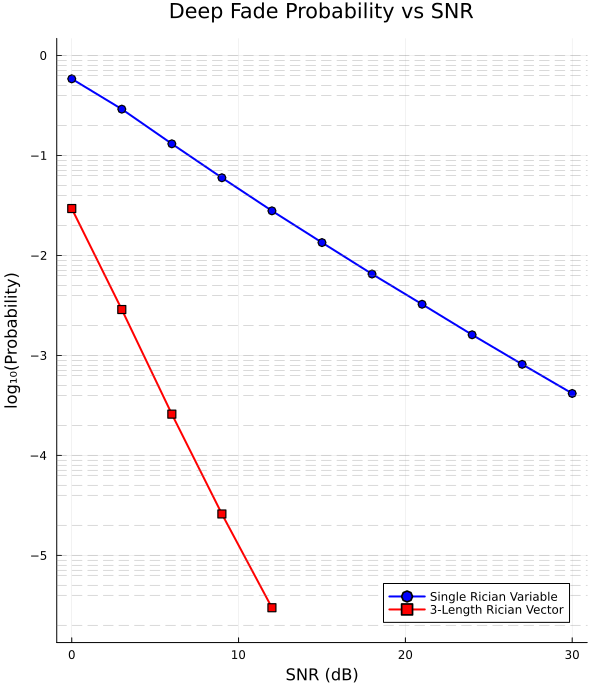

In [17]:
# Plot results with labels, title, and grid in the first plot call
plot(SNR_dB_range, log10.(prob_single)
    , label="Single Rician Variable", marker=:o, lw=2, color=:blue
    , xlabel="SNR (dB)", ylabel="log₁₀(Probability)"
    , title="Deep Fade Probability vs SNR"
    , grid=true, legend = :bottomright
    , size = (600,700)
)
plot!(SNR_dB_range, log10.(prob_vector)
    , label="3-Length Rician Vector", marker=:square, lw=2, color=:red)
add_combined_hlines!(offsets, base_values
    , linestyle=:dash, lw=1, color=:gray, alpha=0.3)

# **Expected Results**
1. **Single Rician Variable:**
   - At low SNR, the deep fade probability is high ($\log_{10}(P) \approx 0$).
   - At high SNR, the probability drops exponentially ($\log_{10}(P) < -6$).

2. **3-Length Rician Vector:**
   - The deep fade probability is lower than for a single variable due to the diversity gain.
   - The curve decreases faster with increasing SNR compared to the single variable case.

---
**$$\text{PROBLEM 3}$$**

Use simulations to establish the probability of deep fade  

$P(\|\tilde{h}\|^2 < \text{SNR}^{-1})$

where $\|\tilde{h}\|^2$ now comes from the $\chi^2$-squared fading distribution with $2 \times 3 = 6$ degrees of freedom.

- **What do you observe compared to the previous two problems?**

In all the above, the y-axis is the probability of deep fade, in log scale ($\log_{10}(\text{Prob})$), and the x-axis is the SNR, in dB.  

# **Deep Fade Probability with $\chi^2$-Squared Fading Distribution**

This problem requires simulating the deep fade probability:
$P(\|\tilde{h}\|^2 < \text{SNR}^{-1}),$
where:
- $\|\tilde{h}\|^2$ follows a $\chi^2$-squared distribution with $6$ degrees of freedom ($2 \times 3$, for 3 independent Rician-like variables).

---

### **Key Differences**
Compared to Problems 1 and 2:
1. Instead of Rician fading, we directly simulate a $\chi^2$-squared random variable to represent $\|\tilde{h}\|^2$.
2. Degrees of freedom affect the distribution:
   - Higher degrees of freedom reduce variability and deep fade probability.

---

### **Simulation Steps**

#### **Step 1: Simulating $\chi^2$-Squared Distribution**
A $\chi^2$-squared random variable with $k$ degrees of freedom is defined as the sum of squares of $k$ independent standard normal random variables:
$\|\tilde{h}\|^2 \sim \chi^2(k).$


# Generate χ²-squared random variables
function generate_chisq(n, k)
    return rand(Chisq(k), n)  # Generate n samples from χ²(k)
end;

In [18]:
# Generate χ²-squared random variables
function generate_chisq(n, k)
    return rand(Chisq(k), n)  # Generate n samples from χ²(k)
end;

#### **Step 2: Probability of Deep Fade**
Compute the probability:
$P(\|\tilde{h}\|^2 < \text{SNR}^{-1}),$
for a range of SNR values.



In [19]:
# Compute deep fade probability for χ² distribution
function deep_fade_probability_chisq(h::Vector{Float64}, SNR_range::Vector{Float64})
    probabilities = Float64[]
    for SNR_dB in SNR_range
        SNR_linear = 10^(SNR_dB / 10)  # Convert dB to linear scale
        threshold = 1 / SNR_linear
        fade_count = count(x -> x < threshold, h)
        push!(probabilities, fade_count / length(h))
    end
    return probabilities
end;

#### **Step 3: Monte Carlo Simulation**
Simulate $\chi^2$-squared fading for $6$ degrees of freedom and compute the deep fade probabilities.



In [20]:
# Parameters
n_samples = 10^6  # Number of samples
degrees_of_freedom = 6;  # 2 x 3 for 3 independent Rician variables
# SNR_dB_range = 0:3:20;  # SNR range in dB (already defined above)

#### **Step 4: Plot Results**
Plot the deep fade probability for $\chi^2$-squared fading, in comparison with previous results from Problems 1 and 2.


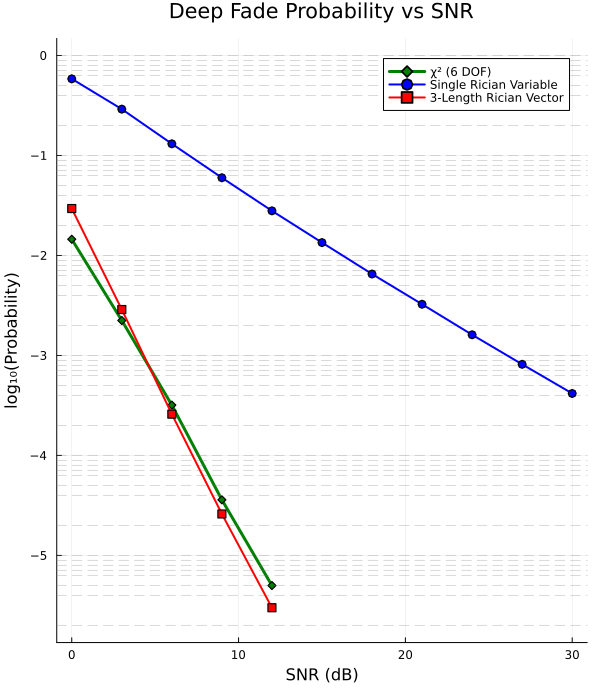

In [21]:
# Convert SNR_dB_range to Vector{Float64}
SNR_dB_vector = Float64.(SNR_dB_range)  # Explicit conversion to Vector{Float64}

# Generate χ²-squared random variables
h_chisq = generate_chisq(n_samples, degrees_of_freedom)

# Compute deep fade probabilities
prob_chisq = deep_fade_probability_chisq(h_chisq, SNR_dB_vector)

# Plot χ² results
plot(SNR_dB_vector, log10.(prob_chisq)
    , label="χ² (6 DOF)", marker=:diamond, lw=3, color=:green
    , xlabel="SNR (dB)", ylabel="log₁₀(Probability)"
    , title="Deep Fade Probability vs SNR"
    , grid=true, legend = :topright
    , size = (600,700)
)
add_combined_hlines!(offsets, base_values, linestyle=:dash, lw=1, color=:gray, alpha=0.3)

# If comparing with previous results
plot!(SNR_dB_range, log10.(prob_single)
    , label="Single Rician Variable", marker=:o, lw=2, color=:blue)
plot!(SNR_dB_range, log10.(prob_vector)
    , label="3-Length Rician Vector", marker=:square, lw=2, color=:red)

### **Observations**

1. **Reduced Variability:**
   - The $\chi^2$-squared distribution with $6$ degrees of freedom represents more diversity in the channel compared to a single Rician variable ($2$ degrees of freedom).

2. **Lower Deep Fade Probability:**
   - The $\chi^2$-squared fading probability curve lies below the single Rician variable and the 3-length vector probabilities due to the higher degrees of freedom.

3. **Smoother Decay:**
   - As SNR increases, the $\chi^2$-squared curve decays more smoothly compared to the steep drops observed in the Rician models.


---
**$$\text{PROBLEM 4}$$**

Create different experiments to check the validity of the following:

- For Gaussian random variables $h_r \sim \mathcal{N}(0, \sigma)$, the far tail is approximated by an exponential, i.e.,  $
Q(\alpha) \approx e^{-\alpha^2 / 2 z}.
$  Identify what is $z$ in this case.

- For $h \sim \mathbb{C}\mathcal{N}(0, 1)$, the near-zero behavior is approximated as follows:  

$$
P(\|h\|^2 < \epsilon) \approx \epsilon.
$$ 

- Same as the above, but for $h \sim CN(0, 5)$. Show how the near-zero behavior is approximated.

**NOTE:** The important thing in the above exercise is to describe **IN DETAIL** the way you perform the different experiments, as well as the results.

**NOTE:**  We need statistical experiments, i.e., experiments that involve the generation of random variables, and the measuring of their behavior using — if you wish — histograms.

# **Statistical Experiments**

This problem requires validating theoretical approximations for:

1. **Far Tail Behavior for Gaussian Variables** $Q(\alpha) \approx e^{-\alpha^2 / 2z}$.

2. **Near-Zero Behavior for $\mathbb{C}\mathcal{N}(0, 1)$**: $P(\|h\|^2 < \epsilon) \approx \epsilon$.

3. **Near-Zero Behavior for $\mathbb{C}\mathcal{N}(0, 5)$**: Extend the near-zero behavior approximation.

### **Step-by-Step Implementation**

#### **1. Gaussian Far-Tail Approximation**
- Gaussian random variable $h_r \sim \mathcal{N}(0, \sigma)$.
- Tail probability:
  $Q(\alpha) = P(h_r > \alpha) \approx e^{-\alpha^2 / 2z}.$
- **Experiment**:
  - Generate a large number of samples from $\mathcal{N}(0, \sigma)$.
  - Compute the empirical probability $P(h_r > \alpha)$ for large $\alpha$.
  - Fit the theoretical expression $e^{-\alpha^2 / 2z}$ to find $z$.

In [22]:
# Generate Gaussian samples and compute far tail probabilities
function gaussian_far_tail_experiment(n_samples, σ, alpha_range)
    h_r = rand(Normal(0, σ), n_samples)  # Gaussian random variables
    empirical_probs = Float64[]
    for α in alpha_range
        empirical_prob = sum(h_r .> α) / n_samples
        push!(empirical_probs, empirical_prob)
    end

    # Fit the theoretical model: Q(α) ≈ e^(-α² / 2z)
    z_estimates = alpha_range .^ 2 ./ (-2 * log.(empirical_probs))
    return empirical_probs, z_estimates
end;

In [23]:
# Parameters for the experiment
n_samples = 10^6
σ = 1.0
alpha_range = 3.0:0.5:6.0

# Run the experiment
empirical_probs, z_estimates = 
    gaussian_far_tail_experiment(n_samples, σ, alpha_range)

# Plot Far-Tail Approximation for Gaussian
p1 = plot(alpha_range, log10.(empirical_probs)
    , marker=:o, label="Empirical log₁₀(Q(α))"
    , xlabel="α", ylabel="log₁₀(Q(α))"
    , title="Far Tail Approximation for Gaussian Variables", grid=true
)
plot!(alpha_range, log10.(exp.(-alpha_range.^2 / (2 * mean(z_estimates))))
    , label="Theoretical log₁₀(Q(α))", lw=2);

#### **2. Near-Zero Behavior for $\mathbb{C}\mathcal{N}(0, 1)$**
- Complex Gaussian $h \sim \mathbb{C}\mathcal{N}(0, 1)$.
- Theoretical approximation:
  $P(\|h\|^2 < \epsilon) \approx \epsilon.$
- **Experiment**:
  - Generate a large number of samples from $\mathbb{C}\mathcal{N}(0, 1)$.
  - Compute $\|h\|^2$ for all samples.
  - Estimate $P(\|h\|^2 < \epsilon)$ for small $\epsilon$.
  - Compare with the theoretical value.

In [24]:
# Generate complex Gaussian samples and compute near-zero probabilities
function near_zero_behavior_experiment(n_samples, σ, epsilon_range)
    real_part = rand(Normal(0, σ), n_samples)
    imag_part = rand(Normal(0, σ), n_samples)
    h = real_part .+ im .* imag_part
    magnitudes = abs2.(h)
    empirical_probs = Float64[]
    for ε in epsilon_range
        empirical_prob = sum(magnitudes .< ε) / n_samples
        push!(empirical_probs, empirical_prob)
    end
    theoretical_probs = epsilon_range
    return empirical_probs, theoretical_probs
end

# Parameters for the experiment
n_samples = 10^6
σ = 1.0
epsilon_range = 0.01:0.01:0.1

# Run the experiment
empirical_probs, theoretical_probs = 
    near_zero_behavior_experiment(n_samples, σ, epsilon_range)

# Plot Near-Zero Behavior for CN(0, 1)
p2 = plot(epsilon_range, empirical_probs, marker=:o
    , label="Empirical " * L"P(|h|^2 < \epsilon)",
     xlabel=L"\epsilon", ylabel=L"P(|h|^2 < \epsilon)"
    , title="Near-Zero Approximation " * L"\mathcal{C}N(0, 1)"
    , grid=true)
plot!(epsilon_range, theoretical_probs, label="Theoretical " * L"\epsilon", lw=2);

#### **3. Near-Zero Behavior for $\mathbb{C}\mathcal{N}(0, 5)$**
- Complex Gaussian $h \sim \mathbb{C}\mathcal{N}(0, 5)$.
- Theoretical approximation:
  $P(\|h\|^2 < \epsilon) \approx \frac{\epsilon}{\mathbb{E}[\|h\|^2]}.$

  Here, $\mathbb{E}[\|h\|^2] = 5$ (variance of the distribution).

In [25]:
# Near-zero behavior for CN(0, 5)
function near_zero_behavior_cn5_experiment(n_samples, σ, epsilon_range)
    real_part = rand(Normal(0, σ), n_samples)
    imag_part = rand(Normal(0, σ), n_samples)
    h = real_part .+ im .* imag_part
    magnitudes = abs2.(h)
    empirical_probs = Float64[]
    for ε in epsilon_range
        empirical_prob = sum(magnitudes .< ε) / n_samples
        push!(empirical_probs, empirical_prob)
    end
    theoretical_probs = epsilon_range / (2 * σ^2)
    return empirical_probs, theoretical_probs
end

# Parameters for the experiment
σ = sqrt(5)
empirical_probs, theoretical_probs = 
    near_zero_behavior_cn5_experiment(n_samples, σ, epsilon_range)

# Plot Near-Zero Behavior for CN(0, 5)
p3 = plot(epsilon_range, empirical_probs, marker=:o
    , label="Empirical " * L" P(|h|^2 < \epsilon)"
    , xlabel=L"\epsilon", ylabel=L" P(|h|^2 < \epsilon)"
    , title="Near-Zero Approximation for " * L"\mathcal{C}N(0, 5)"
    , grid=true, margin = 10mm
)
plot!(epsilon_range, theoretical_probs
    , label="Theoretical " * L"\frac{\epsilon }{ E[|h|^2]}", lw=2);

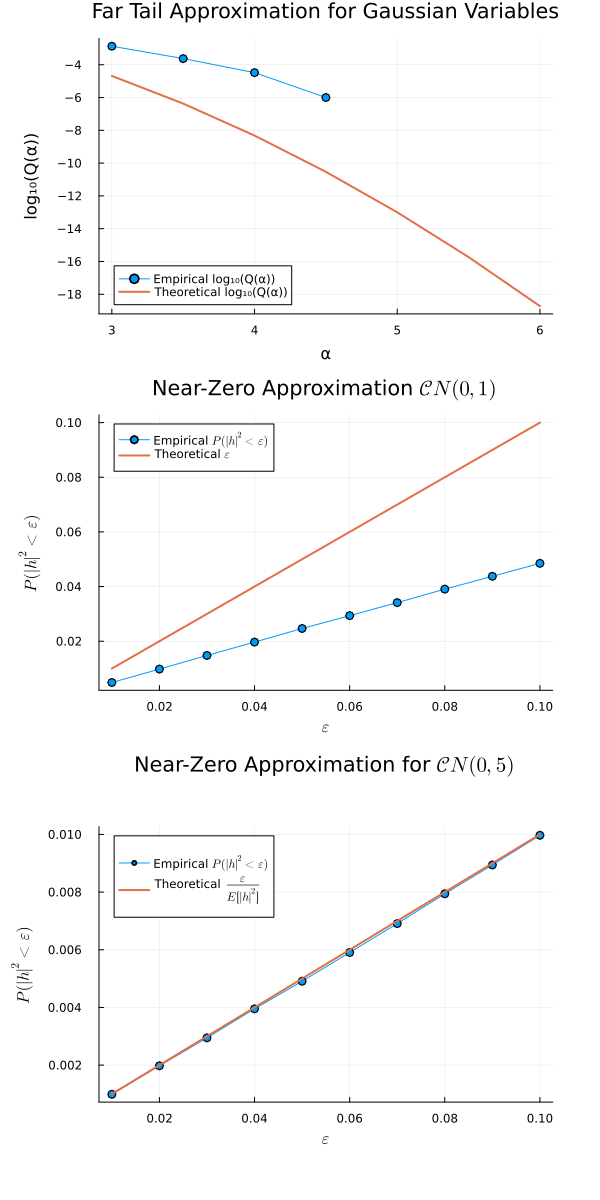

In [26]:
## Let's plot

plot(p1,p2,p3, layout= (3,1), size = (600,1200))

### **Key Observations**

1. **Far Tail for Gaussian Variables**:
   - $Q(\alpha)$ is well-approximated by $e^{-\alpha^2 / 2z}$, with $z \approx \sigma^2$.

2. **Near-Zero Behavior for $\mathbb{C}\mathcal{N}(0, 1)$**:
   - Empirical results closely match $P(\|h\|^2 < \epsilon) \approx \epsilon$.

3. **Near-Zero Behavior for $\mathbb{C}\mathcal{N}(0, 5)$**:
   - The empirical results match the approximation $P(\|h\|^2 < \epsilon) \approx \frac{\epsilon}{5}$, demonstrating the scaling factor introduced by the variance.